In [274]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [275]:
import numpy as np
import pandas as pd

In [276]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [277]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta, date

In [278]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [279]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [280]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [281]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [282]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

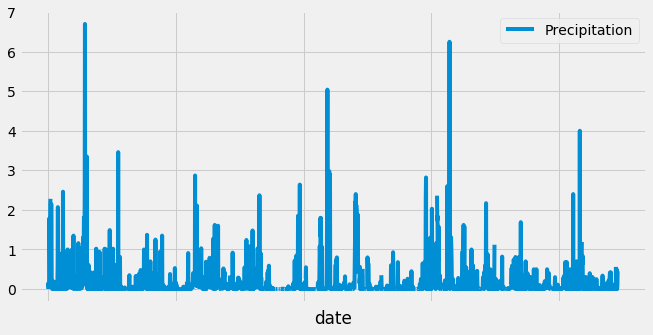

In [283]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
for row in session.query(Measurement.date).all():
    x = row
enddate = x[0]
datetime_object = datetime.strptime(enddate, '%Y-%m-%d')
startdate = datetime_object.replace(datetime_object.year - 1)
y = datetime.strftime(startdate, '%Y-%m-%d')

l = []
qry = session.query(Measurement.date, (Measurement.prcp).label('Precipitation')).filter(Measurement.date >= y).order_by(Measurement.date).all()
for row in qry:
    l.append(row)
precip_data = pd.DataFrame(l)
precip_data = precip_data.set_index('date')
precip_data.plot(figsize=(10,5),legend=4)
plt.show()


![precipitation](Images/precipitation.png)

In [284]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [285]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
stations

9

In [286]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
conn = engine.connect()

active_stations = pd.read_sql("SELECT station Station, COUNT(station) Count FROM measurement GROUP BY station", conn)

active_stations = active_stations.sort_values(by='Count',ascending=False).set_index('Station')
active_stations

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [287]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
li =[]
temp = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').all()
for t in temp:
    li.append(t)
temperatures = [min(li), max(li), np.mean(li)]
temperatures

[(54.0), (85.0), 71.66378066378067]

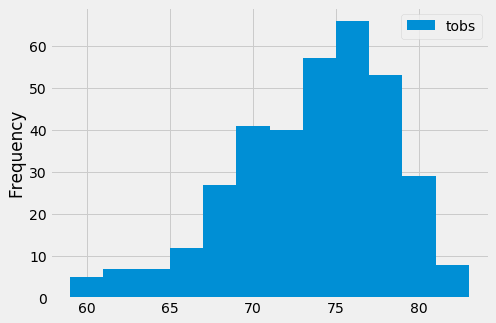

In [288]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_1 = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date >= y).all()
li_1 = []
for x in temp_1:
    li_1.append(x)
df = pd.DataFrame(li_1)
df.plot.hist(bins=12,figsize=(7,5))

![precipitation](Images/station-histogram.png)

In [289]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [305]:
calc = calc_temps('2017-07-12','2017-07-19')
tmin = calc[0][0]
tmax = calc[0][2]
tavg = calc[0][1]
tmin, tavg, tmax
vacation_start = '2017-07-12'
vacation_end = '2017-07-19'

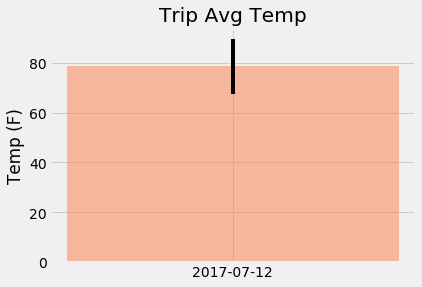

In [322]:
fig, ax = plt.subplots()
fig.tight_layout()
plt.bar(vacation_start,height=tavg,yerr=(tmax-tmin), align = 'center', color='coral',alpha=.5)
plt.ylabel("Temp (F)")
plt.title('Trip Avg Temp')
plt.show()

In [292]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [293]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [294]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
qry = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('prcp')).filter(Measurement.date >= vacation_start).filter(Measurement.date <= vacation_end).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(desc(Measurement.prcp)).all()

print(qry)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.07), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.7), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.2600000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.19), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6400000000000001), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.11)]


## Optional Challenge Assignment

In [295]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = (func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [296]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
end = datetime.strptime(vacation_end,"%Y-%m-%d").strftime('%d')
start = datetime.strptime(vacation_start,"%Y-%m-%d").strftime('%d')
month = datetime.strptime(vacation_start,"%Y-%m-%d").strftime('%m')
daily_norm = []
dates = []
for i in range(int(start),int(end)+1):
    z = month + "-" + str(i)
    daily = daily_normals(z)
    daily_norm.append(daily)
    dates.append(z)
    
normal = []
for i in range(0,8):
    new = daily_norm[i][0]
    normal.append(new)
normal

[(67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0)]

In [297]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal,columns=['tmin','tavg','tmax'])
normal_df['date'] = dates
normal_df = normal_df.set_index('date')
normal_df

,tmin,tavg,tmax
date,,,
07-12,67.0,75.964912,82.0
07-13,69.0,76.189655,81.0
07-14,61.0,76.228070,82.0
07-15,68.0,76.254237,82.0
07-16,70.0,76.344828,83.0
07-17,70.0,76.301887,83.0
07-18,72.0,76.637931,83.0
07-19,68.0,75.890909,83.0


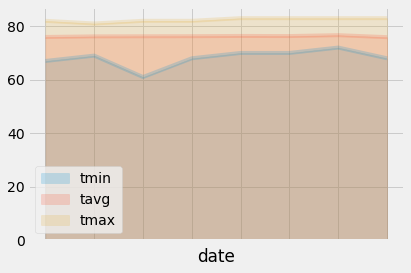

In [323]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False,alpha=.2)
plt.show()

In [300]:
x = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= y).all()
x


[(58.0, 74.59058295964125, 87.0)]